# Fixing Weird Patterns When Plotting NEXRAD Level 3 Data

The motivation here comes from a thread on Twitter, indicating an issue when plotting NEXRAD Level 3 radial velocity (`NOU`).

Here is the radar image, plotted by David ([@dryglick](https://twitter.com/dryglick)):

<img src="../images/nexrad-plotting-issue.jpeg" alt="drawing" width="400"/>

Notice the odd pattern directly north/south and east/west of the radar...

There appears to be a crosshair of grey/darker pixels in our image.

This was identified as a [Moiré Pattern](https://en.wikipedia.org/wiki/Moiré_pattern), by Ryan May ([@dopplershift](https://twitter.com/dopplershift)), lead developer of MetPy, an open source python library for working with meteorological data.

## The Data
We are using [NEXRAD Level 3 Data](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00708), which is ground-based radar data in the United States, defined as:

"NEXRAD Level 3 products are used to remotely detect atmospheric features, such as precipitation, precipitation-type, storms, turbulence and wind, for operational forecasting and data research analysis."

This dataset is provided by the National Oceanic and Atmospheric Administration (NOAA).

### Data Access
We can access this dataset using the [NCEI NEXRAD Level 3 Search Portal](https://www.ncei.noaa.gov/access/search/data-search/weather-radar-level-iii). We **could** access data from Amazon Web Services (AWS) if we were interested in data **after 2020**, but since we are looking at at data from 2018, we need to use the NCEI archive.

David mentioned he was looking at velocity data (`N0U`) from Elgin Air Force Base in the Panhandle of Florida, with the station identifier of `KEVX`, at **1458 UTC on October 10, 2018**, which was hours before [Hurricane Michael](https://www.nhc.noaa.gov/data/tcr/AL142018_Michael.pdf) made landfall along the Gulf Coast.

We can enter the:
- Radar data field (`N0U`)
- Location (`KEVX`)
- Date/time (`10/10/2018 at 1458 UTC`)

into our query. Here is what it should lookl like on the webpage:

<img src="../images/nexrad-level3-radar-query.png" alt="radar-data-query" width="600"/>

Once we add this to our cart, and wait for the data to be sent to our email, we download via HTTP (through a website) or FTP. 

We can now unzip the compressed file, then take a look at our data file, reading in the `N0U` (`velocity`) field.

The specific file we are interested in is:

`KMOB_SDUS54_N0UEVX_201810101458`

## Recreate the Issue Using PyART

### Imports

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pyart
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Read the data using PyART
When reading into PyART, we can use the [`pyart.io.read_level3`](https://arm-doe.github.io/pyart/API/generated/pyart.io.read_nexrad_level3.html#pyart.io.read_nexrad_level3) module, **or**, we can use the [`pyart.io.read`](https://arm-doe.github.io/pyart/API/generated/pyart.io.read.html#pyart.io.read) module which automatically detects the filetype being read in.

In [2]:
radar = pyart.io.read("KMOB_SDUS54_N0UEVX_201810101458")

### Plot our Data Using `RadarMapDisplay`


#### Setting our Matplotlib style
Before we dig into plotting, let's set our background to dark since that is what the original image showed and it will be easier to identify the pattern in the data.

In [3]:
plt.style.use("dark_background")

#### Plot our data without setting `alpha`

Since we want geographical boundaries on our map, let's use `RadarMapDisplay` with our `Radar` object to create the map.

When we create our plot, everything looks okay - we don't see the odd Moiré Pattern...

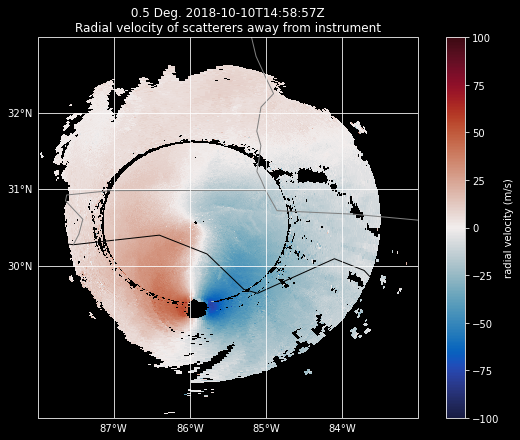

In [4]:
fig = plt.figure(figsize=(10, 7))
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "velocity",
    sweep=0,
    vmin=-100,
    vmax=100,
    projection=ccrs.PlateCarree(),
    colorbar_label="radial velocity (m/s)",
    cmap="pyart_balance",
)
plt.xlim(-88, -83)
plt.ylim(28, 33)
plt.show()

#### Add in the `alpha` argument

When we add in the `alpha=0.8` argument, which adjusts the ***transparency*** of our field, we start to see the pattern. 

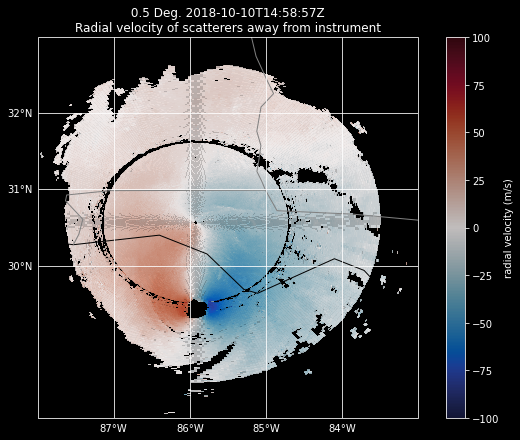

In [5]:
fig = plt.figure(figsize=(10, 7))
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "velocity",
    alpha=0.8,
    sweep=0,
    vmin=-100,
    vmax=100,
    projection=ccrs.PlateCarree(),
    colorbar_label="radial velocity (m/s)",
    cmap="pyart_balance",
)

plt.xlim(-88, -83)
plt.ylim(28, 33)
plt.show()

## Dig into the Issue

### Investigate `plot_ppi_map`
Let's take a look at the specific plotting call being made with `plot_ppi_map` using `??`:

In [6]:
??display.plot_ppi_map

Signature:
display.plot_ppi_map(
    field,
    sweep=0,
    mask_tuple=None,
    vmin=None,
    vmax=None,
    cmap=None,
    norm=None,
    mask_outside=False,
    title=None,
    title_flag=True,
    colorbar_flag=True,
    colorbar_label=None,
    ax=None,
    fig=None,
    lat_lines=None,
    lon_lines=None,
    projection=None,
    min_lon=None,
    max_lon=None,
    min_lat=None,
    max_lat=None,
    width=None,
    height=None,
    lon_0=None,
    lat_0=None,
    resolution='110m',
    shapefile=None,
    shapefile_kwargs=None,
    edges=True,
    gatefilter=None,
    filter_transitions=True,
    embelish=True,
    raster=False,
    ticks=None,
    ticklabs=None,
    alpha=None,
)
Source:   
    def plot_ppi_map(
            self, field, sweep=0, mask_tuple=None,
            vmin=None, vmax=None, cmap=None, norm=None, mask_outside=False,
            title=None, title_flag=True,
            colorbar_flag=True, colorbar_label=None, ax=None, fig=None,
            lat_lines=None, 

We are using `matplotlib.pyplot.pcolormesh` (`plt.pcolormesh`) here to plot our radar data - using the included parameters:
- alpha (data transparency)
- vmin (minimum value to plot)
- vmax (maximum value to plot)
- cmap (colormap to use)
- norm (colormap normalization)
- transform (which projection to use)

For `pcolormesh` parameters **not included in this list**, `pyart` is using the default parameters...

### Investigate `pcolormesh` parameters
In a similar fashion to the `plot_ppi_map` function from `pyart`, we can take a look at the parameters for `plt.pcolormesh`:

In [7]:
?plt.pcolormesh

Signature:
plt.pcolormesh(
    *args,
    alpha=None,
    norm=None,
    cmap=None,
    vmin=None,
    vmax=None,
    shading=None,
    antialiased=False,
    data=None,
    **kwargs,
)
Docstring:
Create a pseudocolor plot with a non-regular rectangular grid.

Call signature::

    pcolormesh([X, Y,] C, **kwargs)

*X* and *Y* can be used to specify the corners of the quadrilaterals.

.. hint::

   `~.Axes.pcolormesh` is similar to `~.Axes.pcolor`. It is much faster
   and preferred in most cases. For a detailed discussion on the
   differences see :ref:`Differences between pcolor() and pcolormesh()
   <differences-pcolor-pcolormesh>`.

Parameters
----------
C : 2D array-like
    The color-mapped values.

X, Y : array-like, optional
    The coordinates of the corners of quadrilaterals of a pcolormesh::

        (X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                              +-----+
                              |     |
                              +-----+
        

#### Digging into `edgecolors`
Notice how one of the arguments included here is `edgecolors`, which by default, is `none`. One of the options here is to set these to be "face", which is the adjacent data color.

Let's test this out with our data to see if changing this parameter makes a difference...

### Try Modifying the `edgecolors` argument with `pcolormesh`
Let's test this out with our data!

First, let's read in the numpy array of data using `['data']`.

In [8]:
velocity = radar.fields["velocity"]["data"]
velocity

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Next, we need to access our coordinates in latitude/longitude form using `get_gate_lat_lon_alt(sweep)`

Since we only have a single sweep, we can set that to 0.

In [9]:
lats, lons, alt = radar.get_gate_lat_lon_alt(0)
lats, lons

(array([[30.565   , 30.562763, 30.560526, ..., 27.888458, 27.886227,
         27.883991],
        [30.565   , 30.562765, 30.560532, ..., 27.892834, 27.890606,
         27.888374],
        [30.565   , 30.562769, 30.56054 , ..., 27.898003, 27.89578 ,
         27.893553],
        ...,
        [30.565   , 30.562756, 30.560509, ..., 27.880096, 27.877857,
         27.875618],
        [30.565   , 30.562756, 30.560513, ..., 27.881853, 27.879616,
         27.877377],
        [30.565   , 30.56276 , 30.560518, ..., 27.884874, 27.88264 ,
         27.880404]], dtype=float32),
 array([[-85.92199 , -85.92222 , -85.92245 , ..., -86.186806, -86.18703 ,
         -86.18723 ],
        [-85.92199 , -85.922264, -85.92254 , ..., -86.2396  , -86.23986 ,
         -86.24012 ],
        [-85.92199 , -85.92231 , -85.92263 , ..., -86.29231 , -86.29262 ,
         -86.29292 ],
        ...,
        [-85.92199 , -85.92208 , -85.92218 , ..., -86.02802 , -86.02811 ,
         -86.0282  ],
        [-85.92199 , -85.92212 , 

#### Plot our data with the default `edgecolors` argument
Notice how our pattern shows up again - we get the Moiré Pattern...

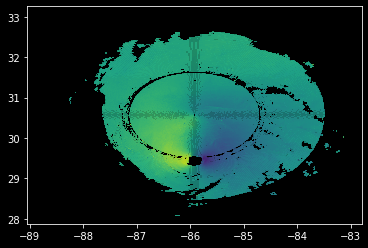

In [10]:
plt.pcolormesh(
    lons,
    lats,
    velocity,
    alpha=0.8,
);

When we try passing in `edgecolors='face'` instead, it goes away!

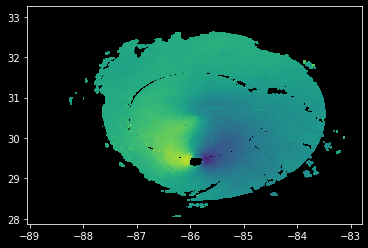

In [11]:
plt.pcolormesh(lons, lats, velocity, alpha=0.8, edgecolors="face");

## Plotting up our Solution
We found the issue! 😁 

Let's plot up the original figure, with features, colorbars, and all!

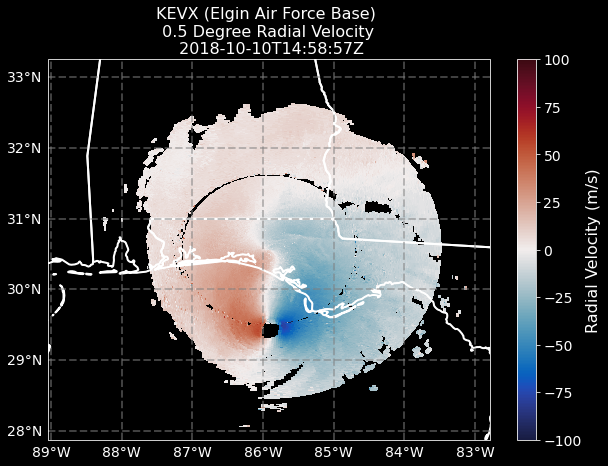

In [14]:
# Setup our figure/geoaxis
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Add state borders and the coastline
ax.add_feature(cfeature.STATES, edgecolor="white", linewidth=2)
ax.add_feature(cfeature.COASTLINE, edgecolor="white")

# Plot our velocity field using pcolormesh with edgecolors argument
mesh = ax.pcolormesh(
    lons, lats, velocity, vmin=-100, vmax=100, edgecolors="face", cmap="pyart_balance"
)

# Configure our colorbar
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Radial Velocity (m/s)", fontsize=16)

# Add gridlines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)

# Make sure labels are only plotted on the left and bottom
gl.xlabels_top = False
gl.ylabels_right = False

# Increase the fontsize of our gridline labels
gl.xlabel_style = {"fontsize": 14}
gl.ylabel_style = {"fontsize": 14}

# Add a title, using time information
plt.title(
    f"KEVX (Elgin Air Force Base) \n 0.5 Degree Radial Velocity \n {radar.time['units'][14:]}",
    fontsize=16,
)

plt.savefig("kevz_velocity_2018_10_10_1458.png", dpi=300)

## Fixing the Issue in PyART

Currently, within PyART, there is not a method of specificying the argument in `plot_ppi_map`, which is why we needed to add that custom section at the end using `plt.pcolormesh` directly.

We are submitting a pull request (PR) to change the default behavior here (`edgecolors='face'`).

**More importantly, this highlights a current limitation of our plotting API where we cannot specify matplotlib.pcolormesh arguments through `plot_ppi_map`. We will make sure this PR adds the ability to specify plotting arguements to pass to `plt.pcolormesh`**

## Conclusion

Within this post, we explored an odd pattern that shows up when setting `alpha` values when plotting radar data using `plot_ppi_map`(`pcolormesh`). We needed to change the `edgecolors` argument in `plt.pcolormesh` to `edgecolors='faces'`.

This also highlighted a need in the `plot_ppi_map` method in PyART to allow users to pass plotting arguments to `pcolormesh`.

We are appreciative of David for raising this question on Twitter, helping us to work together to find a solution and improve our plotting functionality in PyART!